# Preprocessing Data

In [ ]:
# Importing libraries and dependencies
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, BatchNormalization, Input
from keras.models import Model
from keras.losses import SparseCategoricalCrossentropy 
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
from keras import initializers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [2]:
def preprocess_data(feat_path, label_path): # Function for preprocessing the data
    Data_feat = pd.read_csv(feat_path, header=None)
    Data_label = pd.read_csv(label_path, header=None)
    columns = [f'feature_{i+1}' for i in range(Data_feat.shape[1])]
    Data_feat.columns = columns
    Data_label.columns = ['label']
    Data = pd.concat([Data_feat, Data_label], axis = 1)
    return Data

In [3]:
def get_shuffled_data(data): # Function for shuffling the data
    data = data.sample(frac=1)
    X = data.iloc[:,0:-1].values
    y = data.iloc[:,-1].values
    return X, y

In [4]:
# Train, test and validation data has been imported and preprocessed
Data_train = preprocess_data("/kaggle/input/iitm-cs6910-assignment-dataset/task1-20240306T145403Z-001/task1/train_data.csv", "/kaggle/input/iitm-cs6910-assignment-dataset/task1-20240306T145403Z-001/task1/train_label.csv")
Data_val = preprocess_data("/kaggle/input/iitm-cs6910-assignment-dataset/task1-20240306T145403Z-001/task1/val_data.csv", "/kaggle/input/iitm-cs6910-assignment-dataset/task1-20240306T145403Z-001/task1/val_label.csv")
Data_test = preprocess_data("/kaggle/input/iitm-cs6910-assignment-dataset/task1-20240306T145403Z-001/task1/test_data.csv", "/kaggle/input/iitm-cs6910-assignment-dataset/task1-20240306T145403Z-001/task1/test_label.csv")

In [5]:
# Data has been shuffled
X_train, y_train = get_shuffled_data(Data_train)
X_val, y_val = get_shuffled_data(Data_val)
X_test, y_test = Data_test.iloc[:,0:-1].values, Data_test.iloc[:,-1].values

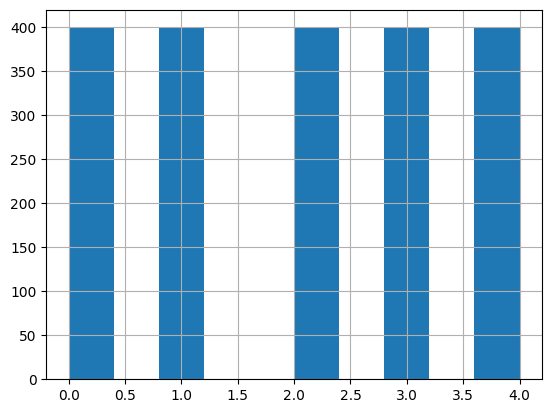

In [6]:
#View the histogram of the train data
Data_train['label'].hist()
plt.show()

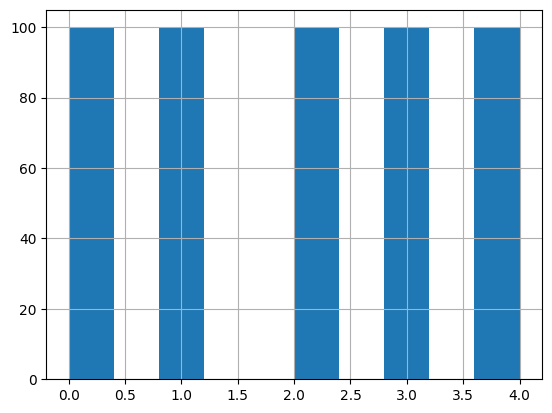

In [7]:
#View the histogram of the train data
Data_val['label'].hist()
plt.show()

**It can be observed in both the histograms that the classes are balanced.**

# Model architecture

In [9]:
initializer = initializers.GlorotUniform(seed=42) # Glorot Uniform Initialization is used for all models
Loss_fnc = SparseCategoricalCrossentropy() # Same loss function is used for all models
lr = 0.001 # Learning rate is fixed

def MLFFN(inputs): # Function defining model architecture
    """
    pass a dataframe object
    """
    h1 = Dense(units = 20, activation = 'tanh', kernel_initializer = initializer)(inputs)
    h2 = Dense(units = 10, activation = 'tanh', kernel_initializer = initializer)(h1)
    output = Dense(units = 5, activation = 'softmax', kernel_initializer = initializer)(h2)
    return output

In [10]:
def Model_training_loop(X_train, y_train, X_val, y_val, optimizer, Loss, optimizer_name:str, epochs=10):
    """
    Function for fitting the model
    optimizer_name: string to get the name of the optimizer
    optimizer: pass the optimizer along with the learning rate
    """
    
    inputs = Input(shape = (36,))
    output = MLFFN(inputs)
    model = Model(inputs = inputs, outputs = output)
    model.compile(loss = Loss, optimizer = optimizer, metrics = ['acc'])
    earl = EarlyStopping(monitor = 'loss', mode = 'auto', min_delta = 0.01, patience = 5, verbose = 1)
    filepath = optimizer_name + '_' + 'best_model_epoch_{epoch}_val_loss_{val_loss:.4f}.keras'
    chkpt = ModelCheckpoint(filepath = filepath, 
                        monitor = 'val_loss', 
                        save_best_only = True, verbose = 1)
    history = model.fit(X_train, y_train, batch_size = 1, validation_data = (X_val, y_val), validation_batch_size = 1, epochs = epochs, callbacks = [earl, chkpt])
    
    
    plt.figure(figsize = (10, 8))
    plt.title(f"Learning curve with {optimizer_name} optimizer", fontsize=22)
    plt.plot(history.history['loss'], label = 'Train loss')
    plt.plot(history.history['val_loss'], label = 'Validation loss')
    plt.legend()
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.show()
    
    return model

In [11]:
def evaluation(model, x, y_true, opt_name, data_name):
    """
    Function for evaluating the model.
    Pass the trained model along with the data,
    please add the name of the data and optimizer name for the plotting purpose
    """
    labels = np.unique(y_true)
    y_pred = np.argmax(model.predict(x), axis = 1)
    CM = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (10, 8))
    plt.title(f"Confusion Matrix for {opt_name} optimizer for {data_name}", fontsize=18)
    sns.heatmap(CM, annot = True, cmap = 'Pastel2', fmt = 'd', linewidths = 1.0)
    plt.yticks(np.arange(len(labels)) + 0.5, labels, fontsize = 14, rotation = 'horizontal')
    plt.xticks(np.arange(len(labels)) + 0.5, labels, fontsize = 14)
    plt.xlabel("Predicted", fontsize = 16)
    plt.ylabel("Actual", fontsize = 16)
    plt.savefig(f"Conf_{opt_name}_{data_name}.png")
    plt.show()

In [12]:
inputs = Input(shape = (36,))
output = MLFFN(inputs)
model = Model(inputs = inputs, outputs = output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,005 (3.93 KB)

 Trainable params: 1,005 (3.93 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
X = Data_train.iloc[:,:-1].values

Check the forward pass before initiating training

In [14]:
model(X)

<tf.Tensor: shape=(2000, 5), dtype=float32, numpy=
array([[0.21200772, 0.3003073 , 0.14153224, 0.22794667, 0.11820599],
       [0.18008764, 0.2768205 , 0.1889864 , 0.21480058, 0.13930488],
       [0.21452568, 0.29252312, 0.15156731, 0.22599049, 0.11539335],
       ...,
       [0.21924554, 0.30387133, 0.15479775, 0.21098328, 0.11110214],
       [0.20042752, 0.2905327 , 0.18740387, 0.19502711, 0.12660877],
       [0.16964775, 0.31751046, 0.14971109, 0.2588728 , 0.10425787]],
      dtype=float32)>

In the below subsections, we will train the MLFFNN using different optimizers and compare their performance.

## 1) Delta Rule

Epoch 1/100
1969/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.2555 - loss: 1.6038
Epoch 1: val_loss improved from inf to 1.55135, saving model to SGD_best_model_epoch_1_val_loss_1.5513.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.2558 - loss: 1.6034 - val_acc: 0.3140 - val_loss: 1.5513
Epoch 2/100
1974/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.3608 - loss: 1.5400
Epoch 2: val_loss improved from 1.55135 to 1.49824, saving model to SGD_best_model_epoch_2_val_loss_1.4982.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - acc: 0.3608 - loss: 1.5399 - val_acc: 0.3840 - val_loss: 1.4982
Epoch 3/100
1982/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.4248 - loss: 1.4756
Epoch 3: val_loss improved from 1.49824 to 1.43374, saving model to SGD_best_model_epoch_3_val_loss_1.4337.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - acc: 0.4247 - loss: 1.4755 - val_acc: 0.4140 - val_loss: 1.4337
Epoch 4/100
1962/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.4113 - loss: 1.4199
Ep

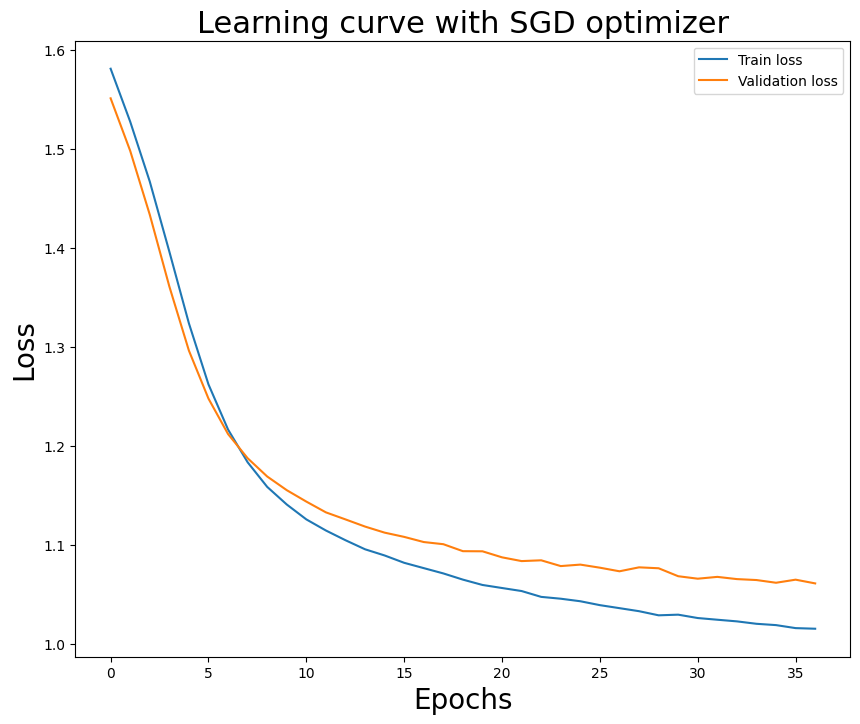

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


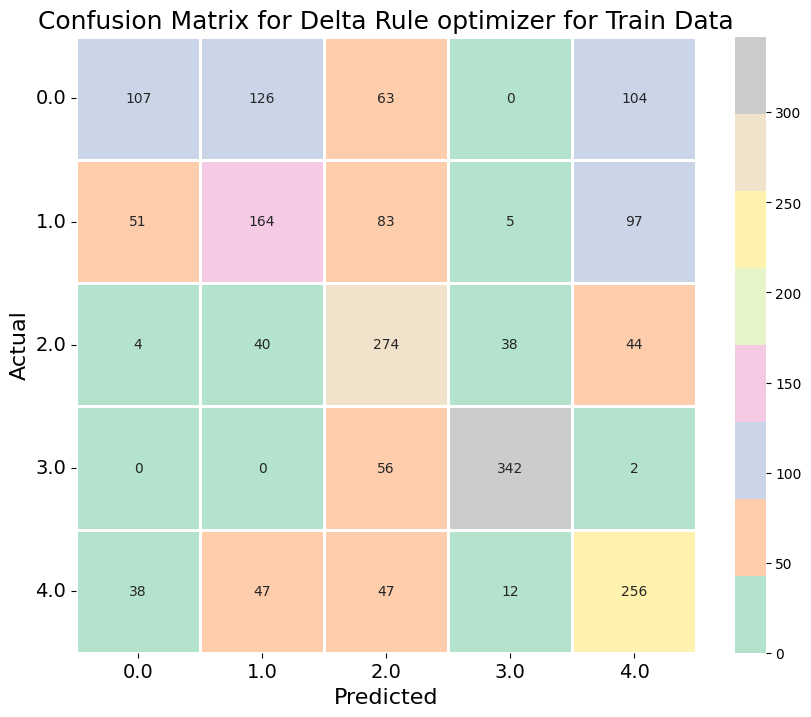

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


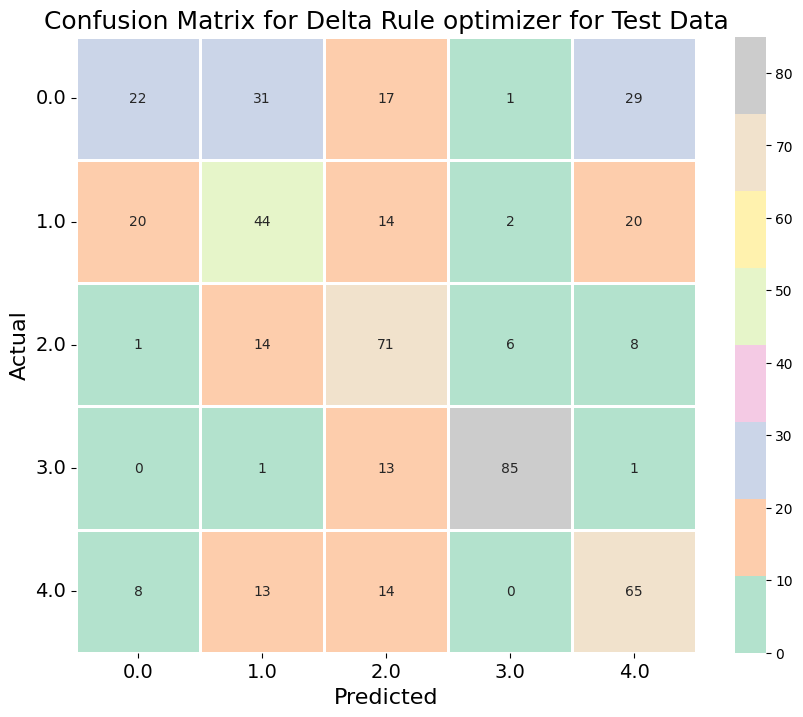

In [15]:
Trained_model=Model_training_loop(X_train, y_train, X_val, y_val, optimizer = keras.optimizers.SGD(learning_rate = lr), Loss = Loss_fnc, optimizer_name = "SGD", epochs = 100)
evaluation(Trained_model, X_train, y_train, "Delta Rule", "Train Data")
evaluation(Trained_model, X_test, y_test, "Delta Rule", "Test Data")

## 2) Generalized Delta Rule

Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.3453 - loss: 1.4020
Epoch 1: val_loss improved from inf to 1.16287, saving model to SGD with momentum_best_model_epoch_1_val_loss_1.1629.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.3454 - loss: 1.4020 - val_acc: 0.4620 - val_loss: 1.1629
Epoch 2/100
1969/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.4885 - loss: 1.1668
Epoch 2: val_loss did not improve from 1.16287
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - acc: 0.4886 - loss: 1.1668 - val_acc: 0.4960 - val_loss: 1.1809
Epoch 3/100
1971/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.5197 - loss: 1.1279
Epoch 3: val_loss did not improve from 1.16287
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - acc: 0.5194 - loss: 1.1284 - val_acc: 0.4900 - val_loss: 1.2527
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.5076 - loss: 1.1403
Epoch 4: val_loss did not improve from 1.16287
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - acc: 0.5075 - loss: 1.1403 -

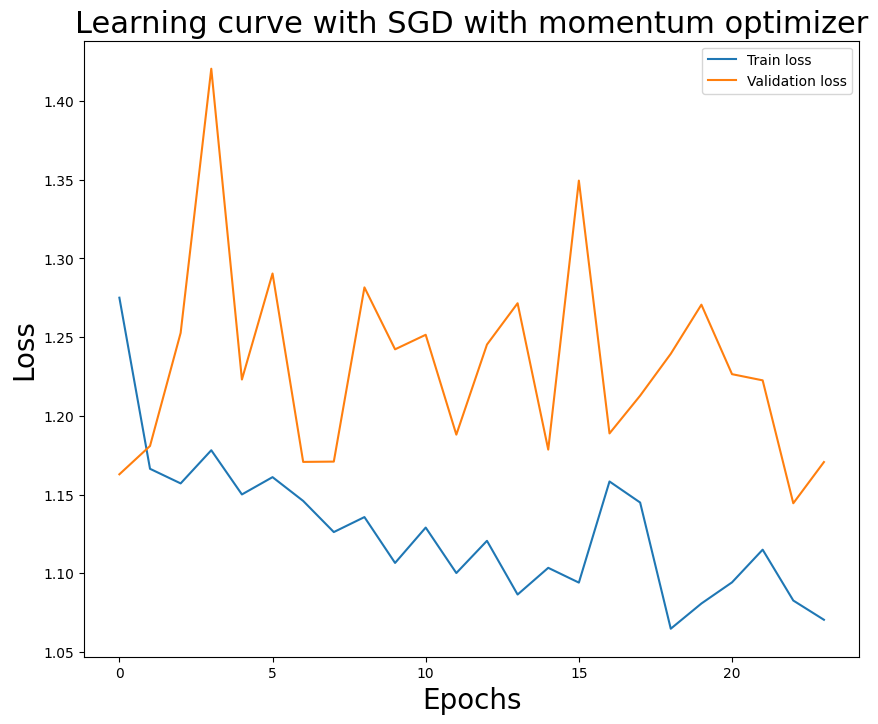

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


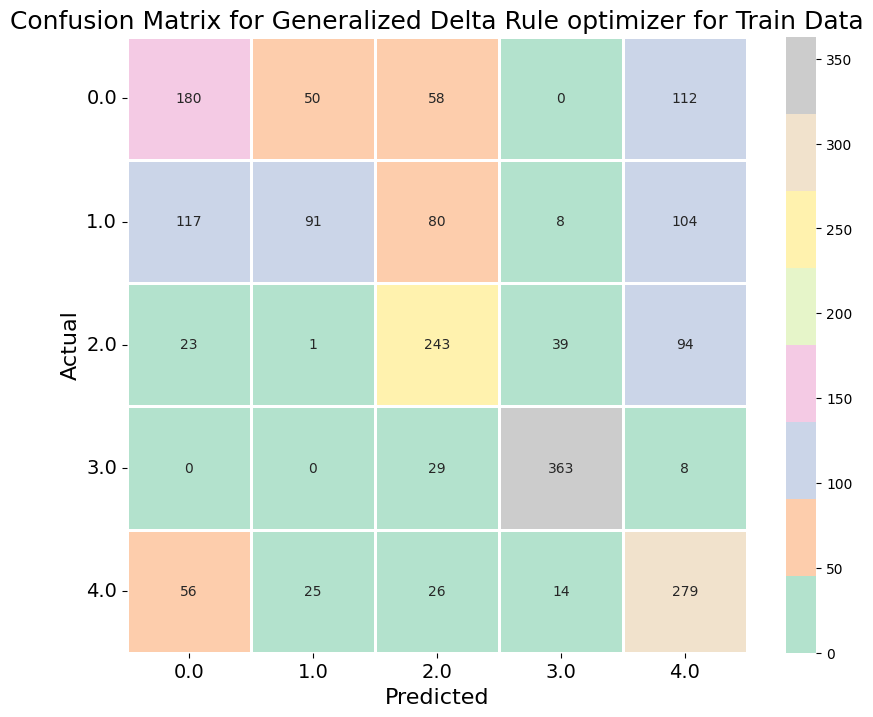

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


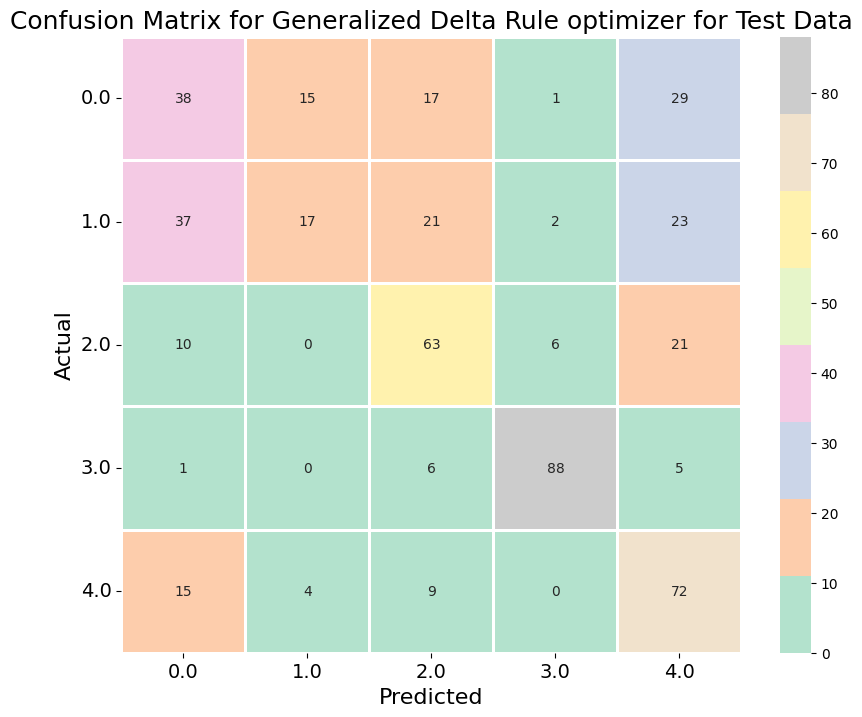

In [16]:
Trained_model = Model_training_loop(X_train, y_train, X_val, y_val, optimizer = keras.optimizers.SGD(learning_rate = lr, momentum = 0.99), Loss = Loss_fnc, optimizer_name = "SGD with momentum", epochs = 100)
evaluation(Trained_model, X_train, y_train, "Generalized Delta Rule", "Train Data")
evaluation(Trained_model, X_test, y_test, "Generalized Delta Rule", "Test Data")

## 3) AdaGrad Optimizer

Epoch 1/100
1988/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.2398 - loss: 1.6035
Epoch 1: val_loss improved from inf to 1.56557, saving model to Adagrad_best_model_epoch_1_val_loss_1.5656.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.2400 - loss: 1.6034 - val_acc: 0.3220 - val_loss: 1.5656
Epoch 2/100
1981/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.3146 - loss: 1.5605
Epoch 2: val_loss improved from 1.56557 to 1.54602, saving model to Adagrad_best_model_epoch_2_val_loss_1.5460.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - acc: 0.3146 - loss: 1.5605 - val_acc: 0.3320 - val_loss: 1.5460
Epoch 3/100
1997/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.3203 - loss: 1.5457
Epoch 3: val_loss improved from 1.54602 to 1.53155, saving model to Adagrad_best_model_epoch_3_val_loss_1.5315.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - acc: 0.3204 - loss: 1.5457 - val_acc: 0.3480 - val_loss: 1.5315
Epoch 4/100
1965/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.3829 - los

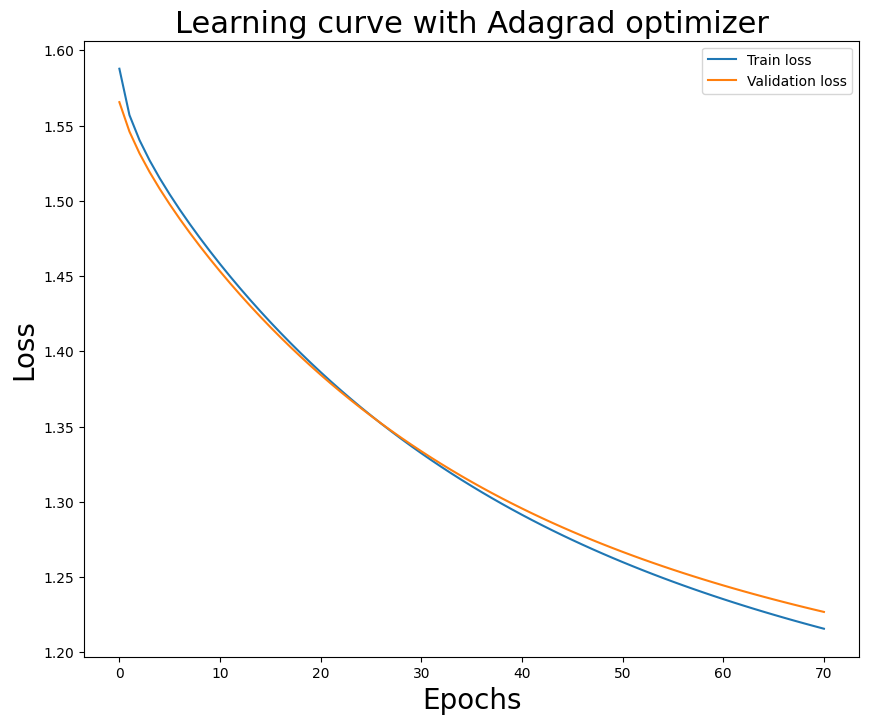

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


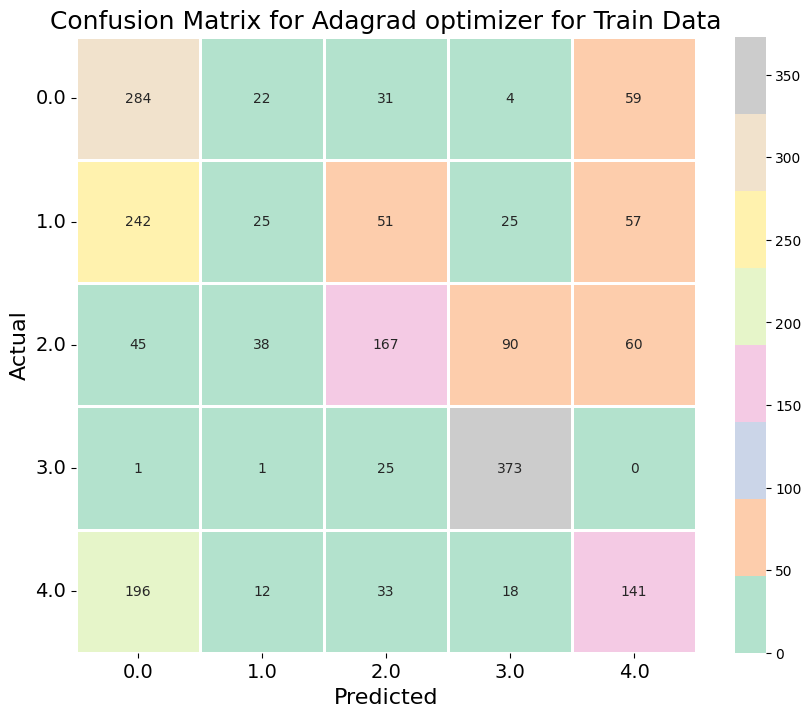

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


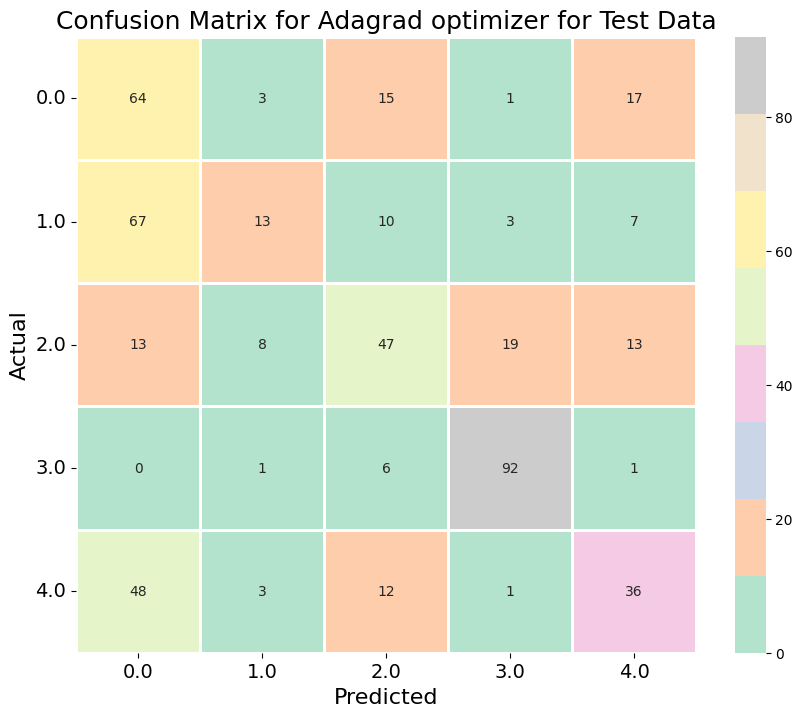

In [17]:
Trained_model = Model_training_loop(X_train, y_train, X_val, y_val, optimizer = Adagrad(learning_rate = lr), Loss = Loss_fnc, optimizer_name = "Adagrad", epochs = 100)
evaluation(Trained_model, X_train, y_train, "Adagrad", "Train Data")
evaluation(Trained_model, X_test, y_test, "Adagrad", "Test Data")

## 4) RMSProp Optimizer

Epoch 1/100
1981/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.3737 - loss: 1.4194
Epoch 1: val_loss improved from inf to 1.13381, saving model to RMSprop_best_model_epoch_1_val_loss_1.1338.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.3744 - loss: 1.4179 - val_acc: 0.5100 - val_loss: 1.1338
Epoch 2/100
1985/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.5293 - loss: 1.0854
Epoch 2: val_loss improved from 1.13381 to 1.09412, saving model to RMSprop_best_model_epoch_2_val_loss_1.0941.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.5293 - loss: 1.0853 - val_acc: 0.5320 - val_loss: 1.0941
Epoch 3/100
1992/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.5445 - loss: 1.0414
Epoch 3: val_loss improved from 1.09412 to 1.07903, saving model to RMSprop_best_model_epoch_3_val_loss_1.0790.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - acc: 0.5445 - loss: 1.0415 - val_acc: 0.5560 - val_loss: 1.0790
Epoch 4/100
1987/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.5366 - los

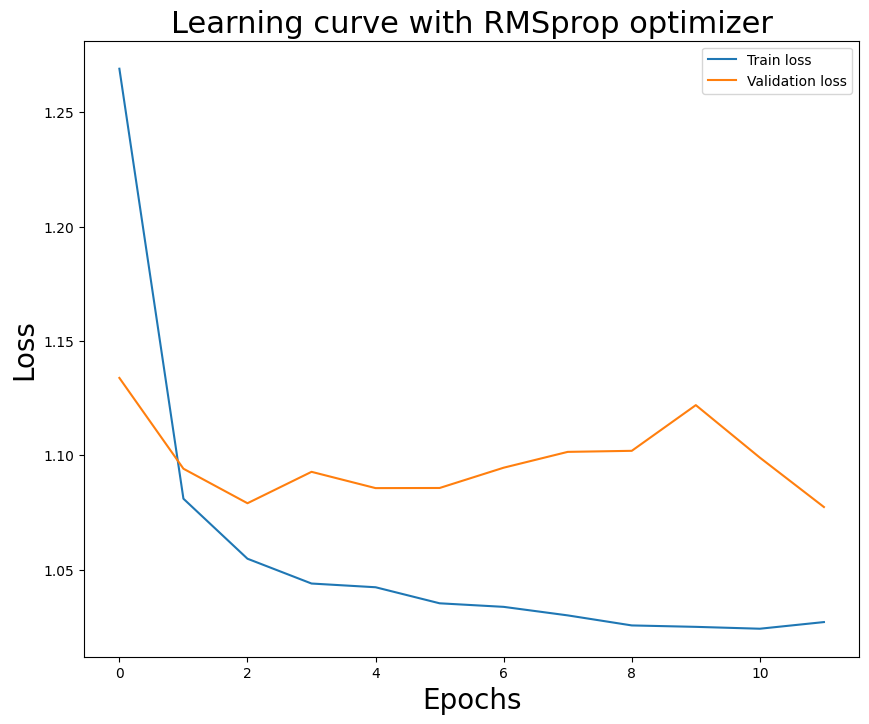

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


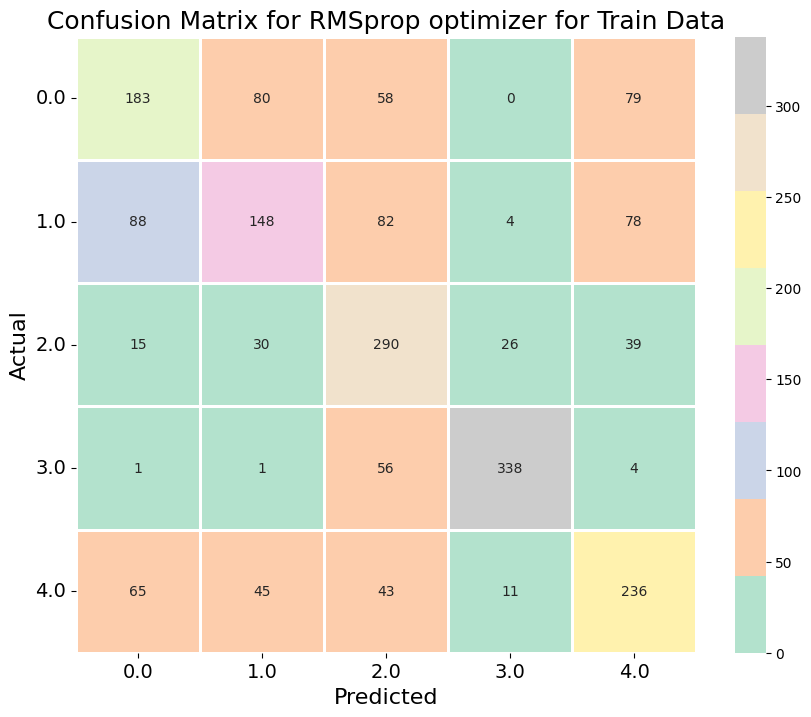

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


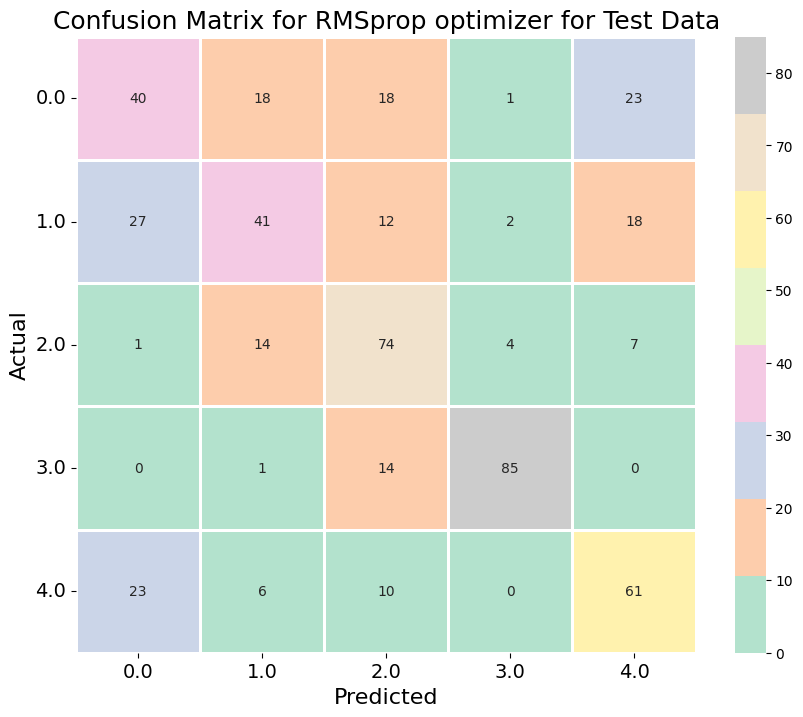

In [18]:
Trained_model = Model_training_loop(X_train, y_train, X_val, y_val, optimizer = RMSprop(learning_rate = lr), Loss = Loss_fnc, optimizer_name = "RMSprop", epochs = 100)
evaluation(Trained_model, X_train, y_train, "RMSprop", "Train Data")
evaluation(Trained_model, X_test, y_test, "RMSprop", "Test Data")

## 5) Adam Optimizer

Epoch 1/100
1984/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.3840 - loss: 1.4016
Epoch 1: val_loss improved from inf to 1.12884, saving model to Adam_best_model_epoch_1_val_loss_1.1288.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - acc: 0.3846 - loss: 1.4003 - val_acc: 0.5140 - val_loss: 1.1288
Epoch 2/100
1981/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.5305 - loss: 1.0927
Epoch 2: val_loss improved from 1.12884 to 1.08227, saving model to Adam_best_model_epoch_2_val_loss_1.0823.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.5305 - loss: 1.0925 - val_acc: 0.5420 - val_loss: 1.0823
Epoch 3/100
1990/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.5620 - loss: 1.0322
Epoch 3: val_loss improved from 1.08227 to 1.07725, saving model to Adam_best_model_epoch_3_val_loss_1.0772.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - acc: 0.5619 - loss: 1.0323 - val_acc: 0.5400 - val_loss: 1.0772
Epoch 4/100
1976/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.5483 - loss: 1.0440

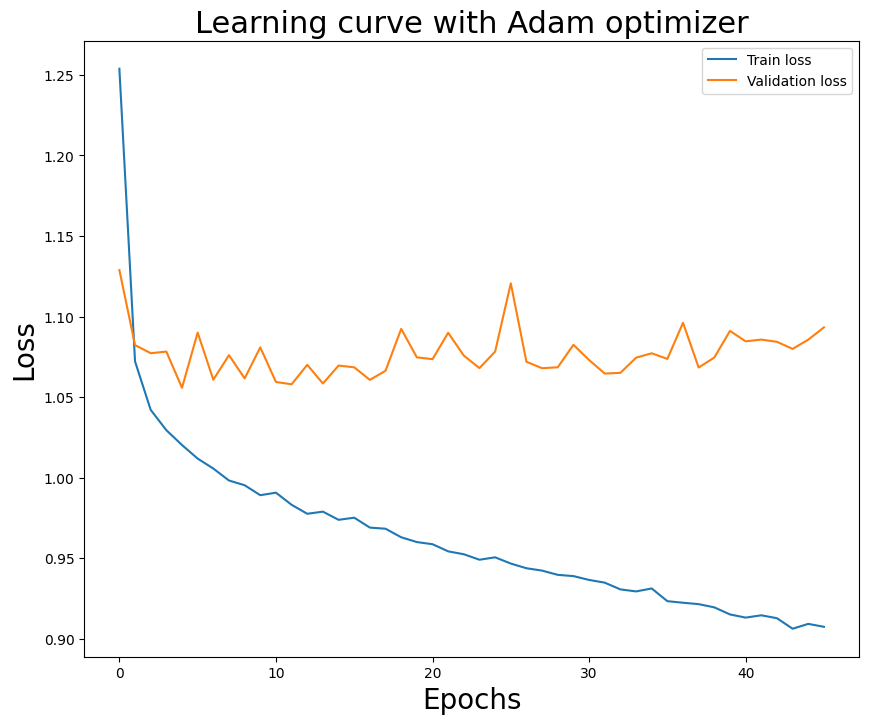

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


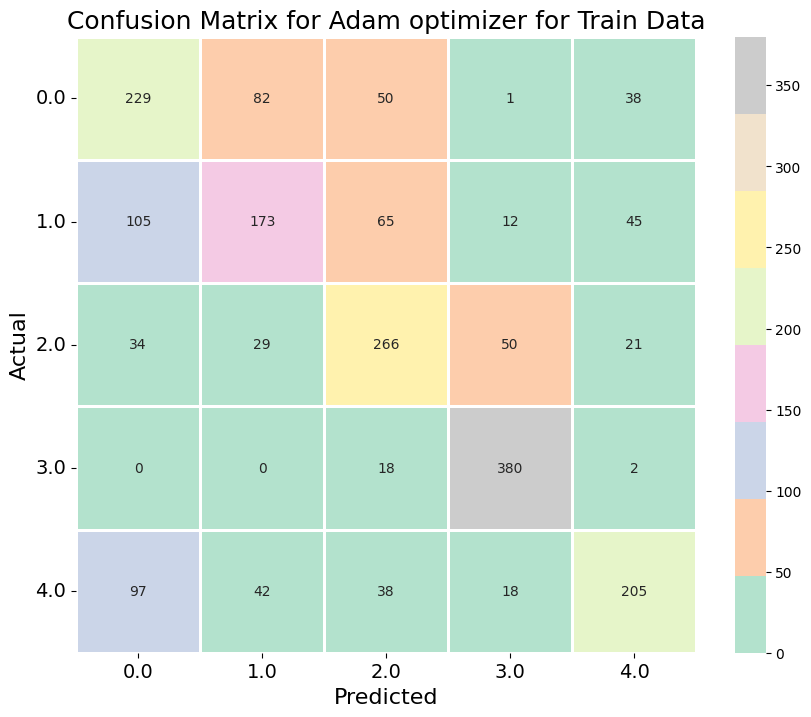

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


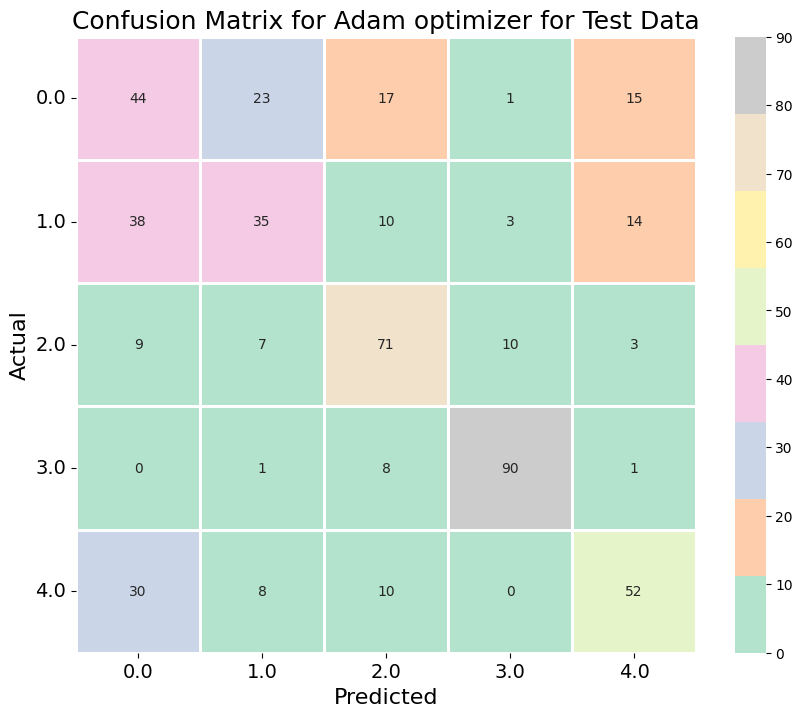

In [19]:
Trained_model = Model_training_loop(X_train, y_train, X_val, y_val, optimizer = Adam(learning_rate = lr), Loss = Loss_fnc, optimizer_name = "Adam", epochs = 100)
evaluation(Trained_model, X_train, y_train, "Adam", "Train Data")
evaluation(Trained_model, X_test, y_test, "Adam", "Test Data")